# Connect To Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/CMP/"

Mounted at /content/drive


# Local

In [1]:
root = './'

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

# Data Preparation

In [4]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root+'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [5]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [6]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

In [7]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

In [8]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [9]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
word_df = pd.concat([elp_words, elp_nonwords])

# 
word_df.fillna(0, inplace=True)
word_df['category'] = word_df.apply(lambda row: categorise_by_zipf(row), axis=1)
word_df.drop_duplicates(subset=['string'], inplace=True)

In [10]:
word_df = word_df.sample(frac=1.0)
word_df.head()

,string,freq,represention,code,label,zipf,category
19023,introspect,70,"[0.00022031758, -0.034748506, 0.03639817, -0.0...","[1, 0]",1,1.592864,LF
21921,ficroscopes,0,"[-0.014173408, -0.018246477, 0.030102564, 0.00...","[0, 1]",0,0.000000,NW
13812,mollicle,0,"[-0.0020688379, -0.0017019745, 0.04827957, 0.0...","[0, 1]",0,0.000000,NW
13587,find,378725,"[-0.00023601623, -0.011677815, 0.0716282, 0.02...","[1, 0]",1,5.918995,HF
12111,entities,6504,"[-0.0025044167, -0.033046506, 0.0378185, -0.00...","[1, 0]",1,2.783196,LF


In [11]:
word_df.drop_duplicates(subset=['string'], inplace=True)

In [12]:
word_df.groupby('category').count()

,string,freq,represention,code,label,zipf
category,,,,,,
HF,14333,14333,14333,14333,14333,14333
LF,19645,19645,19645,19645,19645,19645
NW,40339,40339,40339,40339,40339,40339


In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(list(word_df['represention'])), word_df['label'].to_numpy(), test_size=0.2, shuffle=True)

# SVM

## GridSearch

In [13]:
param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]
svc_clf = SVC()
svc_cv = GridSearchCV(svc_clf, param_grid, cv=5, n_jobs=7, verbose=10)
svc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=7,
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [14]:
print("tuned hpyerparameters :(best parameters) ", svc_cv.best_params_)
print("best accuracy :", svc_cv.best_score_)
print("mean accuracies :", svc_cv.cv_results_['mean_test_score'])

tuned hpyerparameters :(best parameters)  {'C': 10, 'kernel': 'linear'}
best accuracy : 0.9911358563299848
mean accuracies : [0.99047988 0.99113586 0.99096766 0.96217179 0.54254621 0.98161572
 0.96218861 0.9883101  0.98161572]


## SVM fit by best params

tuned hpyerparameters :(best parameters)  {'C': 10, 'kernel': 'linear'}

In [14]:
# SVM_classifier = SVC(C=svc_cv.best_params_['C'],
#                      kernel=svc_cv.best_params_['kernel'],
#                      probability=True, verbose=1)
# SVM_classifier.fit(X_train, y_train)

In [15]:
SVM_classifier = SVC(C=10,
                     kernel='linear',
                     probability=True, verbose=1)
SVM_classifier.fit(X_train, y_train)

[LibSVM]

SVC(C=10, kernel='linear', probability=True, verbose=1)

In [16]:
acc_score = SVM_classifier.score(X_test, y_test)
print(acc_score)

0.9918595263724435


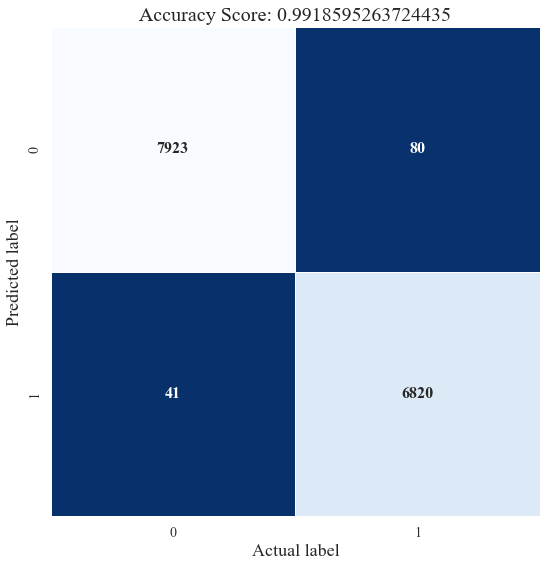

In [17]:
test_predictions = SVM_classifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig('./Plots/Classification/SVM_test_ACC.pdf')

# Get Probabilities on full dataset


In [18]:
full_predictions = SVM_classifier.predict(np.array(list(word_df['represention'])))
acc_score = SVM_classifier.score(np.array(list(word_df['represention'])), word_df['label'].to_numpy())
print(acc_score)

0.9925454472058883


In [19]:
print(metrics.classification_report(word_df['label'].to_numpy(), full_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9955    0.9907    0.9931     40339
           1     0.9890    0.9947    0.9919     33978

    accuracy                         0.9925     74317
   macro avg     0.9923    0.9927    0.9925     74317
weighted avg     0.9926    0.9925    0.9925     74317



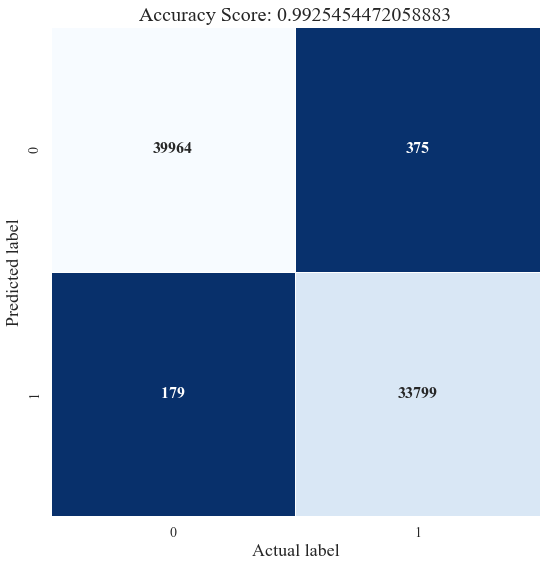

In [20]:
cm = metrics.confusion_matrix(word_df['label'].to_numpy(), full_predictions)
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig('./Plots/Classification/SVM_full_ACC.pdf')

In [21]:
full_dataset_predictions = SVM_classifier.predict_proba(np.array(list(word_df['represention'])))

In [22]:
word_df['word_prob'] = full_dataset_predictions[:,1]
word_df['nword_prob'] = full_dataset_predictions[:,0]

In [23]:
word_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                     nword_prob            \
              mean       std  count  max           min       mean       std   
category                                                                      
HF        0.989732  0.057391  14333  1.0  9.194977e-07   0.010268  0.057391   
LF        0.980463  0.080626  19645  1.0  1.157033e-04   0.019537  0.080626   
NW        0.013702  0.083196  40339  1.0  1.000000e-07   0.986298  0.083196   

                                         
          count       max           min  
category                                 
HF        14333  0.999999  3.000001e-14  
LF        19645  0.999884  3.000001e-14  
NW        40339  1.000000  1.000840e-12

In [24]:
word_df_to_save = word_df.drop(['represention', 'code'], axis=1)

In [25]:
word_df_to_save.to_csv(root+"Datasets/fastText_SVM.csv", header=0, index=False)